In [1]:
import pickle
import pandas as pd
import numpy as np
from spiker import *
import matplotlib.pyplot as plt
from rnn import rnn

In [2]:
# https://www.mathworks.com/help/ident/ref/goodnessoffit.html
def goodness_of_fit(ann_states, snn_states):
    nmse_layers = []
    epsilon = 1e-14
    layers = range(len(ann_states))
    transient = 10000
    for idx in layers: # layer idx
        dims = ann_states[idx].shape[0]
        nmse = []
        for jdx in range(dims):
            ref = ann_states[idx][jdx,transient:]
            y = snn_states[idx][jdx,transient:]
            diff = ref - y
            num = np.sum(diff*diff)
            ref_ch_mean = np.mean(ref)
            ref_diff = ref - ref_ch_mean #+ epsilon
            den = np.sum(ref_diff*ref_diff)
            if (den < epsilon) | (num < epsilon):
                if num < den:
                    nmse += [1]
            else:
                nmse += [1 - (num/den)]
        nmse_layer = np.mean(nmse)
        print(f'MSE in layer {idx} is {nmse_layer:.3f}')
        nmse_layers += [nmse_layer]
    return nmse_layers
# goodness_of_fit(ann_states, snn_states)

In [3]:
def plot_activations(net, ann_states, rnn_states, label=''):
    plt.rcParams['lines.linewidth'] = 1.2
    import matplotlib.patches as mpatches
    # Plotting and visualization
    print('Pole frequency = {0:.3f} Hz'.format(1/net.tau))
    goodness = goodness_of_fit(ann_states, snn_states)
    for idx in range(len(ann_states)): # layer idx
        dims = ann_states[idx].shape[0]
        if dims >= 3:
            cols = 3
        else:
            cols=dims
        rows = int(np.ceil(dims/cols))
        fig, axs = plt.subplots(rows,cols)
        for jdx in range(ann_states[idx].shape[0]): # dim idx
            ax = plt.subplot(rows,cols,jdx+1)
            plt.plot(tsteps, ann_states[idx][jdx,:], color='r', linestyle='-.', label=f'ANN - Layer {idx}')
            plt.plot(tsteps, snn_states[idx][jdx,:], color='g', alpha=0.7, label=f'SNN - Layer {idx}')
            plt.axis('off')
            plt.subplots_adjust(wspace=0, hspace=0)
            
        label_ext = r' $c_{v_p} = $'+f'{mismatch}.'+f' NMSE = {goodness[idx]:.3f}.'
            
        if idx == 0:
            fig.suptitle(f'Input dense layer.'+label_ext, fontsize=12)
        elif idx == len(ann_states)-1:
            fig.suptitle(f'Output dense layer.'+label_ext, fontsize=12)
        elif idx%2 == 1:
            fig.suptitle(f'Recurrent layer {int(np.floor((idx+1)/2))}.'+label_ext, fontsize=12)
        else:
            fig.suptitle(f'Dense layer {int(np.floor((idx)/2))}.'+label_ext, fontsize=12)
        patch1 = mpatches.Patch(color='g', label='ANN output')
        patch2 = mpatches.Patch(color='r', label='SNN output')
        fig.tight_layout() # Or equivalently,  "plt.tight_layout()"
        fig.legend(handles=[patch1, patch2], loc='lower center', fancybox=True, shadow=True, fontsize=12, ncol=2)
        plt.savefig(f'./img/ANN-RNN-Layer-{idx}-{label}.png', dpi=300)
    t = 0
    for N in net.neurons:
        t += np.sum(N.spike_count)
    print('Average spike rate = {0:.3f} KHz'. format(1e-3*t/(tsteps[-1]*op_dim+res_dim+ip_dim)))

Sequence length is 200000


(2, 200000)

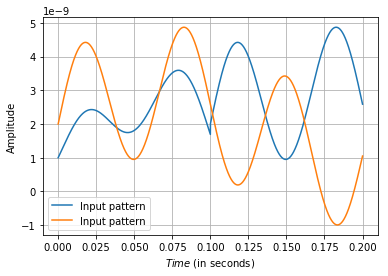

In [4]:
# Generate simulation data
def gen_data(nblocks,f1,f2, tstart=0, tstop=0.0001, Ts=1e-6,amp=1e-9):
    """
    Generates a time series comprising nblocks of data
    Each block is some combination of two sinusoids.
    nblocks = number of blocks
    tseries = Tseries object. Tseries is a datastructure 
        that makes it easy to deal with time-series data
    amp = Scales the entire data block
    """
    #np.random.seed(1)
    tseries = gen_time(tstart,tstop,Ts) # obtain the time series input sample
    time = tseries.time
    ip = np.array([])
    op = np.array([])
    tblockend = int(len(time)/nblocks)
    timeblock = time[:tblockend]
    for index in range(nblocks):
        if np.random.randint(2):
            block = 2*np.sin(2*np.pi*timeblock*f2)+1*np.sin(2*np.pi*timeblock*f1)+2
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.zeros_like(timeblock)))
        else:
            block = 1*np.sin(2*np.pi*timeblock*f2)+2*np.sin(2*np.pi*timeblock*f1)**2+1
            ip = np.concatenate((ip,block))
            op = np.concatenate((op,np.ones_like(timeblock)))
    return amp*ip, amp*op, time
# Some input
ip1,_,tsteps = gen_data(nblocks=2, f1=4, f2=15, tstop=0.2)
ip2,_,tsteps = gen_data(nblocks=1, f1=4, f2=15, tstop=0.2)

inp1 = Tseries(ip1, tsteps)
inp2 = Tseries(ip2, tsteps)
inp1.plot(label = "Input pattern")
inp2.plot(label = "Input pattern")
ip = np.stack((ip1,ip2))
print('Sequence length is {}'.format(ip.shape[1]))
ip.shape# = (1,ip.shape[0])

In [5]:
def run_rnns(ip, ip_dim, op_dim, res_dim, nrlayers, nparams):
    net = rnn(nrlayers, ip_dim, res_dim, op_dim, nparams=nparams)
    ann_states = net.rnn_forward(ip, mode='ann')
    snn_states = net.rnn_forward(ip, mode='snn')
    return ann_states, snn_states, net

In [6]:
# Test case to study effect of mismatch
ip_dim = ip.shape[0]
op_dim = 3
res_dim = 500
nrlayers = 4
seq_len = ip.shape[1]
nparams = {}
nmse_avgs = {}
nmse_stds = {}
nruns = 20
mismatch_list = [0, 0.2, 1, 1.5, 2]
for mismatch in mismatch_list:
    print('='*89)
    print(f'Running {nruns} tests with mismatch std = {mismatch}')
    nmse_runs = []
    for _ in range(nruns):
        print(f'Test #{_+1}/{nruns}'+'-'*10)
        nparams['mismatch'] = mismatch
        ann_states, snn_states,_ = run_rnns(ip, ip_dim, op_dim, res_dim, nrlayers, nparams)
        nmse_runs += [goodness_of_fit(ann_states, snn_states)]
    nmse_runs = np.array(nmse_runs)
    nmse_avgs[r'$\sigma$ '+f' = {mismatch}'] = np.mean(nmse_runs, axis=0)
    nmse_stds[r'$\sigma$ '+f' = {mismatch}']  = np.std(nmse_runs, axis=0)
#     plt.semilogy(range(len(ann_states)), nmse_avgs[mismatch], label = f'Mismatch std = {mismatch}')
nmse_avgs = pd.DataFrame.from_dict(nmse_avgs)
nmse_stds = pd.DataFrame.from_dict(nmse_stds) 
results = (nmse_avgs, nmse_stds)
with open(f'./img/mapping_mismatch_r{res_dim}.pickle', 'wb') as handle:
    pickle.dump(results, handle, protocol=pickle.HIGHEST_PROTOCOL)

Running 20 tests with mismatch std = 0
Test #1/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 0.995
MSE in layer 3 is 0.985
MSE in layer 4 is 0.988
MSE in layer 5 is 0.969
MSE in layer 6 is 0.979
MSE in layer 7 is 0.908
MSE in layer 8 is 0.933
Test #2/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.978
MSE in layer 2 is 0.955
MSE in layer 3 is 0.899
MSE in layer 4 is 0.919
MSE in layer 5 is 0.782
MSE in layer 6 is 0.811
MSE in layer 7 is -0.100
MSE in layer 8 is 0.603
Test #3/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.997
MSE in layer 2 is 0.985
MSE in layer 3 is 0.972
MSE in layer 4 is 0.977
MSE in layer 5 is 0.949
MSE in layer 6 is 0.951
MSE in layer 7 is 0.624
MSE in layer 8 is 0.891
Test #4/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.993
MSE in layer 2 is 0.971
MSE in layer 3 is 0.952
MSE in layer 4 is 0.959
MSE in layer 5 is 0.907
MSE in layer 6 is 0.912
MSE in layer 7 is 0.407
MSE in layer 8 is 0.807
Test #5/20--

MSE in layer 1 is 0.816
MSE in layer 2 is 0.750
MSE in layer 3 is -4.591
MSE in layer 4 is 0.284
MSE in layer 5 is -19.411
MSE in layer 6 is -0.126
MSE in layer 7 is -7.246
MSE in layer 8 is -0.977
Test #15/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.989
MSE in layer 2 is 0.967
MSE in layer 3 is 0.671
MSE in layer 4 is 0.806
MSE in layer 5 is -3.861
MSE in layer 6 is 0.472
MSE in layer 7 is -4.740
MSE in layer 8 is 0.366
Test #16/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 0.995
MSE in layer 3 is 0.582
MSE in layer 4 is 0.768
MSE in layer 5 is -17.415
MSE in layer 6 is 0.475
MSE in layer 7 is -6.147
MSE in layer 8 is 0.663
Test #17/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.684
MSE in layer 2 is 0.614
MSE in layer 3 is -4.626
MSE in layer 4 is 0.098
MSE in layer 5 is -12.821
MSE in layer 6 is -0.175
MSE in layer 7 is -6.266
MSE in layer 8 is -0.204
Test #18/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.922
MSE in 

MSE in layer 3 is -134.823
MSE in layer 4 is -6.813
MSE in layer 5 is -553.568
MSE in layer 6 is -12.975
MSE in layer 7 is -339.919
MSE in layer 8 is -7.969
Test #7/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.998
MSE in layer 2 is 0.977
MSE in layer 3 is -9.836
MSE in layer 4 is -2.629
MSE in layer 5 is -681.676
MSE in layer 6 is -8.820
MSE in layer 7 is -579.442
MSE in layer 8 is -10.404
Test #8/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 0.996
MSE in layer 3 is -1.491
MSE in layer 4 is -0.412
MSE in layer 5 is -368.001
MSE in layer 6 is -6.359
MSE in layer 7 is -309.015
MSE in layer 8 is -6.847
Test #9/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is -7.352
MSE in layer 2 is -9.584
MSE in layer 3 is -110.954
MSE in layer 4 is -15.121
MSE in layer 5 is -380.968
MSE in layer 6 is -16.383
MSE in layer 7 is -254.556
MSE in layer 8 is -10.603
Test #10/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 0.991


MSE in layer 5 is -1562.971
MSE in layer 6 is -28.175
MSE in layer 7 is -755.241
MSE in layer 8 is -71.634
Test #19/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 0.977
MSE in layer 2 is 0.948
MSE in layer 3 is -357.111
MSE in layer 4 is -12.247
MSE in layer 5 is -720.717
MSE in layer 6 is -23.085
MSE in layer 7 is -394.300
MSE in layer 8 is -35.063
Test #20/20----------
MSE in layer 0 is 1.000
MSE in layer 1 is 1.000
MSE in layer 2 is 0.997
MSE in layer 3 is 0.738
MSE in layer 4 is 0.789
MSE in layer 5 is -308.302
MSE in layer 6 is -7.971
MSE in layer 7 is -468.760
MSE in layer 8 is -6.514


In [12]:
with open(f'./img/mapping_mismatch_r{res_dim}.pickle', 'rb') as handle:
    nmse_avgs, nmse_stds = pickle.load(handle)

In [13]:
label = []
for idx in range(2*nrlayers+1):
    if idx == 0:
        label += [f'Input dense layer']
    elif idx == len(ann_states)-1:
        label += [f'Output dense layer']
    elif idx%2 == 1:
        label += [f'Recurrent layer {int(np.floor((idx+1)/2))}']
    else:
        label += [f'Dense layer {int(np.floor((idx)/2))}']

def dump_df(df, label):
    layer_names = df['Layer'].values
    indices = df.index.values.tolist()
    df.T.columns = layer_names
    df = df.set_index('Layer')
    with open(f'./img/mismatch_sims_{label}.tex', 'w') as tf:
         tf.write(df.to_latex(escape=False, float_format=lambda x: '%.1f' % x))
    return df

In [14]:
# nmse_stds['Layer'] = label
# nmse_avgs['Layer'] = label
# nmse_avgs.set_index('Layer')
# nmse_stds.set_index('Layer')
# avg_df = dump_df(nmse_avgs, "avg")
# std_df = dump_df(nmse_stds, "std")
merged_df = pd.concat([avg_df.T, std_df.T], keys=['Mean', 'Std']).T
merged_df ['Layer'] = label
merged_df = dump_df(merged_df, '')
merged_df

Mean                                \
                          $\sigma$  = 0 $\sigma$  = 0.2 $\sigma$  = 1   
Layer                                                                   
Input feed-forward layer       1.000000        1.000000      1.000000   
Recurrent layer 1              0.972794        0.918209      0.775912   
Feed-forward layer 1           0.953405        0.882664      0.739842   
Recurrent layer 2              0.925418       -1.756643    -51.532177   
Feed-forward layer 2           0.934336        0.557157     -2.810537   
Recurrent layer 3              0.789503       -8.428098   -153.348481   
Feed-forward layer 3           0.871161        0.201816     -5.454127   
Recurrent layer 4              0.441167       -7.579201   -130.673186   
Output feed-forward layer      0.768031       -0.292270     -6.464469   

                                                                  Std  \
                          $\sigma$  = 1.5 $\sigma$  = 2 $\sigma$  = 0   
Layer                                                                   
Input feed-forward layer         1.000000      1.000000      0.000000   
Recurrent layer 1                0.407117      0.492687      0.042385   
Feed-forward layer 1             0.191902      0.297212      0.054947   
Recurrent layer 2              -85.622488   -151.838631      0.070422   
Feed-forward layer 2            -4.412009     -8.161560      0.065037   
Recurrent layer 3             -361.933956   -702.433815      0.243665   
Feed-forward layer 3           -10.054924    -17.538755      0.124909   
Recurrent layer 4             -288.509454   -394.726488      0.622027   
Output feed-forward layer      -10.018090    -17.590143      0.176890   

                                                                         \
                          $\sigma$  = 0.2 $\sigma$  = 1 $\sigma$  = 1.5   
Layer                                                                     
Input feed-forward layer         0.000000      0.000000        0.000000   
Recurrent layer 1                0.096537      0.609486        1.903498   
Feed-forward layer 1             0.117885      0.686735        2.474448   
Recurrent layer 2                2.271998     54.563486       96.607992   
Feed-forward layer 2             0.189923      2.372861        3.875810   
Recurrent layer 3                4.307216     77.720957      123.046926   
Feed-forward layer 3             0.240716      1.922337        2.252531   
Recurrent layer 4                3.599663     47.910669      128.341920   
Output feed-forward layer        0.575373      6.351338        6.886888   

                                         
                          $\sigma$  = 2  
Layer                                    
Input feed-forward layer       0.000000  
Recurrent layer 1              1.378294  
Feed-forward layer 1           1.899583  
Recurrent layer 2            126.102454  
Feed-forward layer 2           6.050711  
Recurrent layer 3            279.000848  
Feed-forward layer 3           5.175597  
Recurrent layer 4            203.931341  
Output feed-forward layer     15.212341